In [1]:
%matplotlib inline

In [2]:
from grale.all_nb import *
renderers.setDefaultLensPlaneRenderer(None)
feedback.setDefaultFeedback("none")

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [3]:
cosm = cosmology.Cosmology(0.7, 0.27, 0, 0.73)
zd = 0.5
zs1 = 1.2
zs2 = 1.8
D = cosm.getAngularDiameterDistance

In [4]:
nsie = lenses.NSIELens(D(zd), { "velocityDispersion": 1300000, "ellipticity": 0.8, "coreRadius": 1.5*ANGLE_ARCSEC })

In [5]:
src1 = images.EllipticalSource(V(10,5)*ANGLE_ARCSEC, 1.1*ANGLE_ARCSEC, 0.6, 30, fade=False)

In [6]:
src2 = images.EllipticalSource(V(2, -4.5)*ANGLE_ARCSEC, 1.0*ANGLE_ARCSEC, 0.4, 110, fade=False)

In [7]:
lensInfo = plotutil.LensInfo(nsie, size=80*ANGLE_ARCSEC, numxy=1023, zd=zd, zs=zs1, cosmology=cosm)

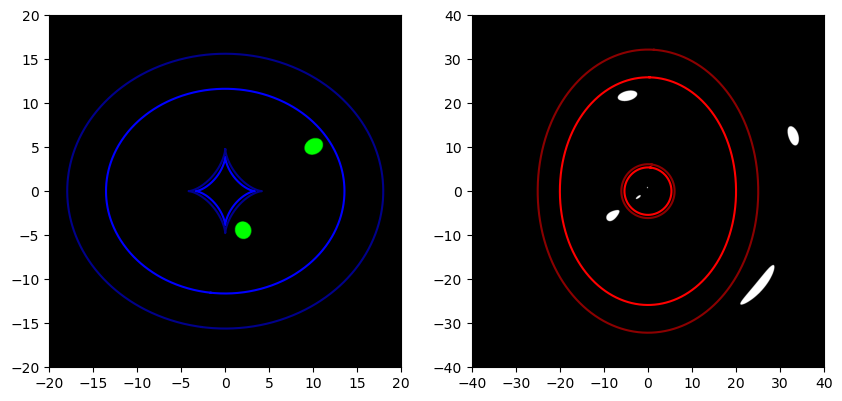

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plotutil.plotImagePlane(lensInfo, sources=[
    { "shape": src1, "z": zs1 },
    { "shape": src2, "z": zs2 }
], critColor = [ 'red', 'darkred'], caustColor = [ 'blue', 'darkblue'], plotCriticalLines=False, plotImages=False)
plt.gca().set_xlim([-20,20])
plt.gca().set_ylim([-20,20]);
plt.subplot(1,2,2)
plotutil.plotImagePlane(lensInfo, sources=[
    { "shape": src1, "z": zs1 },
    { "shape": src2, "z": zs2 }
], critColor = [ 'red', 'darkred'], caustColor = [ 'blue', 'darkblue'], plotCaustics=False, plotSources=False)


In [9]:
def getImagesData(lensInfo, src, zs):
    lensInfo.setSourceRedshift(zs)
    ip = lensInfo.getImagePlane()
    pts = ip.segment(ip.renderImages([src]))
    imgDat = images.ImagesData(len(pts))
    for idx in range(len(pts)):
        for pt in pts[idx]:
            imgDat.addPoint(idx, pt)
            
    return imgDat

In [10]:
imgDat1 = getImagesData(lensInfo, src1, zs1)
imgDat2 = getImagesData(lensInfo, src2, zs2)

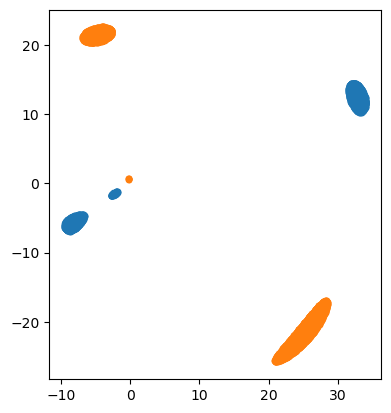

In [11]:
plotutil.plotImagesData([imgDat1, imgDat2])
plt.gca().set_aspect("equal")

In [12]:
# This is a port of lens/new/scaledegen from graleshell

def getMaxRadius(images, center):
    maxRadiusExpandFactor = 1.01 # TODO: make this configurable?
    
    maxRadius = 0
    for imgDat in images:
        allPts = np.array([ p["position"] for img in imgDat.getAllImagePoints() for p in img ])
        dists = np.sum((allPts - center)**2, axis=1)**0.5
        maxRadius = max(maxRadius, max(dists))
        
    maxRadius *= maxRadiusExpandFactor #  make it slightly larger
    return maxRadius

def getRadiiAndDensities(zd, center, imagesAndRedshifts, cosmology):
    numPoints = 100000 # TODO: make this configurable?
    maxRadius = getMaxRadius([d["imgdata"] for d in imagesAndRedshifts], center)
    radialStep = maxRadius/(numPoints-1)
    
    Dd = cosmology.getAngularDiameterDistance(zd)
    
    sourceNumber = np.ones((numPoints,), dtype=int) * (-1)
    criticalDensity = []
    
    for s, imgInfo in enumerate(imagesAndRedshifts):
        imgDat = imgInfo["imgdata"]
        zs = imgInfo["z"]
        Ds = cosmology.getAngularDiameterDistance(zs)
        Dds = cosmology.getAngularDiameterDistance(zd, zs)
        criticalDensity.append(lenses.getCriticalDensity(Dd, Ds, Dds))
        
        for img in imgDat.getAllImagePoints():
            
            imgPts = [ p["position"] for p in img ]
            dists = np.sum((imgPts - center)**2, axis=1)**0.5
                        
            maxIndex = int(max(dists)/radialStep) + 1
            minIndex = int(min(dists)/radialStep) - 1
            
            maxIndex = min(maxIndex, numPoints-1)
            minIndex = max(minIndex, 0)
            
            for p in range(minIndex, maxIndex+1):
                if not (sourceNumber[p] == -1 or sourceNumber[p] == s):
                    raise Exception("Overlapping image regions; can't construct a scale degeneracy")
                    
                sourceNumber[p] = s
            
    startRadii, endRadii, criticalMasses = [], [], []
    done, index = False, 0
    while not done:
        while index < numPoints and sourceNumber[index] < 0: # (*)
            index += 1
            
        if index >= numPoints:
            done = True
        else:
            # Found start of an image
            currentSourceNumber = sourceNumber[index]
            startRadii.append(index * radialStep)
            criticalMasses.append(criticalDensity[currentSourceNumber])

            # Look for the end of image
            while sourceNumber[index] == currentSourceNumber and index < numPoints:
                sourceNumber[index] = -1 # we need to set this to -1, otherwise (*) might fail if two regions touch
                index += 1
                
            if index >= numPoints:
                done = True
                
            index -= 1
            endRadii.append(index*radialStep)

    return Dd, maxRadius, startRadii, endRadii, criticalMasses
            
def createCircularScaleDegenLens(zd, center, imagesAndRedshifts, cosmology):
    
    Dd, maxRadius, startRadii, endRadii, criticalMasses = getRadiiAndDensities(zd, center, imagesAndRedshifts, cosmology)

    numAnnuli = len(startRadii)
    newLensParams = []
    for i in range(numAnnuli):
        
        if i == 0:
            newLensParams.append({
                "xoffset": 0,
                "yoffset": 0,
                "xscale": endRadii[i],
                "yscale": np.pi*Dd*Dd*criticalMasses[i]*endRadii[i]*endRadii[i],
                "xend": endRadii[i],
                "coeffs": [ 0, 0, 1]
            })
        else:
            
            # Interpolated part
            
            startRadius = endRadii[i-1]
            endRadius = startRadii[i]
            
            startMass = np.pi*Dd*Dd*startRadius*startRadius*criticalMasses[i-1]
            endMass = np.pi*Dd*Dd*endRadius*endRadius*criticalMasses[i]
            startSlope = 2.0*np.pi*Dd*Dd*startRadius*criticalMasses[i-1]
            endSlope = 2.0*np.pi*Dd*Dd*endRadius*criticalMasses[i]

            height = endMass-startMass
            width = endRadius-startRadius
            scaledStartSlope = startSlope*width/height
            scaledEndSlope = endSlope*width/height

            coefficients = [ 0, 
                             scaledStartSlope,
                             3.0 - 2.0*scaledStartSlope-scaledEndSlope,
                             -2.0 + scaledStartSlope + scaledEndSlope ]

            newLensParams.append({
                "xoffset": startRadius,
                "yoffset": startMass,
                "xscale": width,
                "yscale": height,
                "xend": endRadius,
                "coeffs": coefficients
            })

            # Constrained part
            
            width = endRadii[i]-startRadii[i]
            coefficients = [ 0, 2.0*startRadii[i]/width, 1 ]
            
            newLensParams.append({
                "xoffset": startRadii[i],
                "yoffset": np.pi*Dd*Dd*criticalMasses[i]*startRadii[i]*startRadii[i],
                "xscale": width,
                "yscale": np.pi*Dd*Dd*criticalMasses[i]*width*width,
                "xend": endRadii[i],
                "coeffs": coefficients
            })
            
    if numAnnuli > 0: # Finish the profile
        startRadius = endRadii[numAnnuli-1]
        endRadius = maxRadius
        startMass = np.pi*Dd*Dd*startRadius*startRadius*criticalMasses[numAnnuli-1]
        startSlope = 2.0*np.pi*Dd*Dd*startRadius*criticalMasses[numAnnuli-1]
        endSlope = 0

        width = endRadius-startRadius
        height = 0.5*width*startSlope

        scaledStartSlope = startSlope*width/height

        coefficients = [ 0, scaledStartSlope, -0.5*scaledStartSlope ]
        newLensParams.append({
            "xoffset": startRadius,
            "yoffset": startMass,
            "xscale": width,
            "yscale": height,
            "xend": endRadius,
            "coeffs": coefficients
        })

    return lenses.PolynomialMassProfileLens(Dd, newLensParams), startRadii, endRadii

In [13]:
degenPart, startRadii, endRadii = createCircularScaleDegenLens(zd, V(0,-5)*ANGLE_ARCSEC, [{"imgdata": imgDat1, "z": zs1},
                                                                    {"imgdata": imgDat2, "z": zs2}], cosm)

In [14]:
degen = lenses.CompositeLens(D(zd),
    [
        { "x": 0, "y": 0, "angle": 0, "factor": 0.75, "lens": nsie },
        { "x": 0, "y": -5*ANGLE_ARCSEC, "angle": 0, "factor": 0.25, "lens": degenPart}
    ])

In [15]:
iws = inversion.InversionWorkSpace(zd, 80*ANGLE_ARCSEC, cosmology=cosm)
iws.addImageDataToList(imgDat1, zs1, "extendedimages")
iws.addImageDataToList(imgDat2, zs2, "extendedimages")

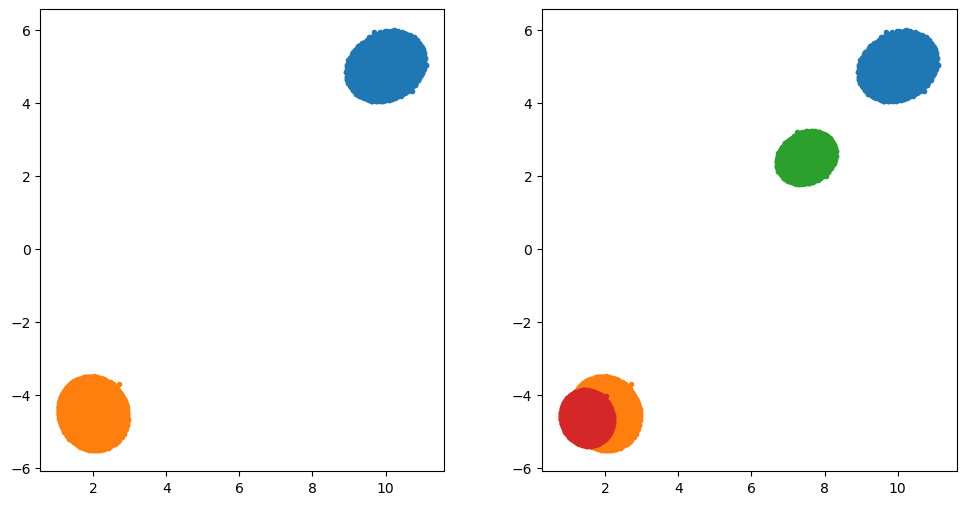

In [16]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plotutil.plotImagesData(iws.backProject(nsie))
plt.gca().set_aspect("equal")
plt.subplot(1,2,2)
plotutil.plotImagesData(iws.backProject(nsie) + iws.backProject(degen))
plt.gca().set_aspect("equal")

(0.0, 12.0)

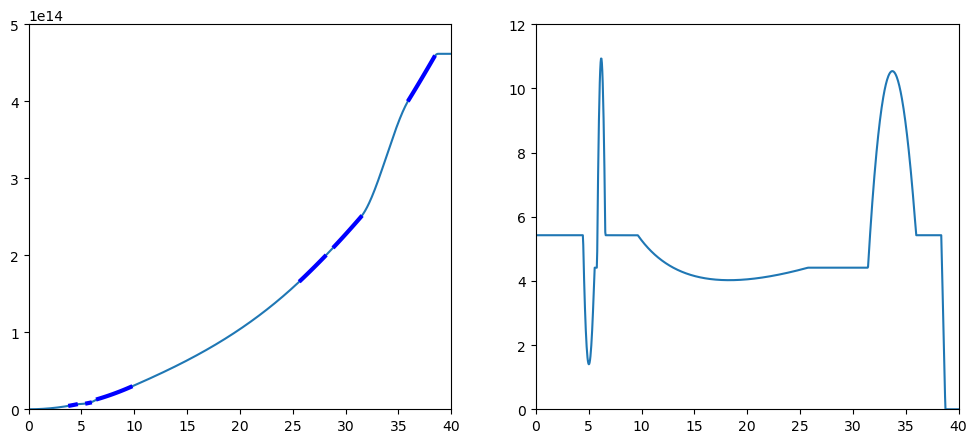

In [17]:
x = np.linspace(0,40,1000)*ANGLE_ARCSEC

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(x/ANGLE_ARCSEC, degenPart.getRadialMassProfile(x)/MASS_SUN)
for i in range(len(startRadii)):
    x2 = np.linspace(startRadii[i], endRadii[i])
    plt.plot(x2/ANGLE_ARCSEC, degenPart.getRadialMassProfile(x2)/MASS_SUN, lw=3, color="blue")
    
plt.gca().set_xlim([0,40])
plt.gca().set_ylim([0,5e14])

plt.subplot(1,2,2)
plt.plot(x/ANGLE_ARCSEC, degenPart.getRadialDensityProfile(x))
plt.gca().set_xlim([0,40])
plt.gca().set_ylim([0,12])

In [18]:
lensInfoDegen = plotutil.LensInfo(degen, size=80*ANGLE_ARCSEC, numxy=1023, zd=zd, zs=zs1, cosmology=cosm)

(0.0, 40.0)

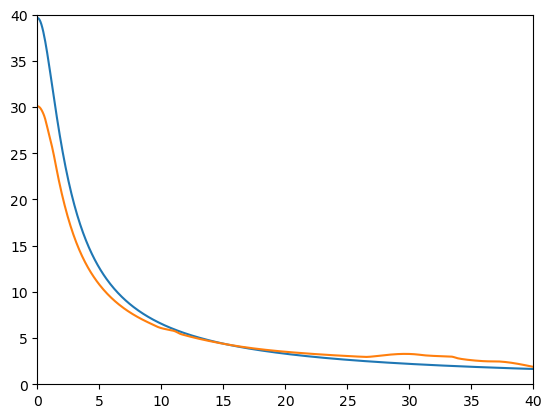

In [19]:
plotutil.plotAverageDensityProfile(lensInfo, 40*ANGLE_ARCSEC)
plotutil.plotAverageDensityProfile(lensInfoDegen, 40*ANGLE_ARCSEC)
plt.gca().set_xlim([0,40])
plt.gca().set_ylim([0,40])

In [20]:
centerPoints = np.array([ [-6.09821,-6.19758],
[-5.7199,-4.84022],
[9.52318,17.0136],
[-7.63676,-5.55814],
[-5.72912,-9.28125],
[-5.52072,-4.34146],
[9.9883,15.2665],
[-6.72137,-3.73556],
[-6.71566,-8.77121],
[-5.71018,-4.81528],
[7.79201,15.3044],
[-9.26493,-8.70192],
[-6.79349,-4.62678],
[9.31674,16.1598],
[-6.33438,-3.05848],
[-6.55666,-3.87596],
[6.87085,14.6803],
[-7.07736,-4.10191],
[-5.65995,-6.44905],
[7.50086,14.7729],
[8.59179,16.2069],
[-5.09311,-8.12494],
[7.81057,15.2726],
[-6.1925,-6.79681],
[-8.8512,-8.10139],
[9.38693,18.1604],
[-5.85055,-8.46279],
[-7.50187,-4.58061],
[-3.74926,-7.28931],
[8.08548,15.0026],
[9.677,15.6931],
[-7.94637,-3.91047],
[-8.80781,-8.1635],
[-8.2878,-5.67287],
[-7.59542,-4.58483],
[-6.57751,-8.83569],
[6.62119,15.8481],
[8.84231,14.7714],
[-6.45902,-7.52517],
[6.71246,14.9273],
[-5.63925,-6.49729],
[-6.93364,-5.31684],
[7.5882,14.7174],
[9.92126,16.273],
[-6.05354,-4.65774],
[-7.08744,-5.30367],
[10.3013,15.6344],
[-7.41834,-3.59577],
[-4.84911,-8.27623],
[-6.32051,-5.23646],
[-5.6341,-6.47785],
[-5.88314,-9.20021],
[-7.52773,-4.54354],
[9.44997,16.0377],
[4.37238,13.8466],
[-6.96418,-5.31451],
[-8.72809,-8.23489],
[-8.97635,-8.01851],
[-5.10676,-5.99517],
[-6.0236,-7.77429],
[-6.21412,-7.5637],
[-5.39713,-5.36002],
[-8.1357,-5.89245],
[6.74828,14.8803],
[-6.35372,-7.4247],
[-4.67444,-6.34366],
[-6.2729,-8.29566],
[-6.15728,-6.0775],
[-6.63656,-8.05283],
[-6.93606,-7.04178],
[9.27351,18.3294],
[-8.17334,-9.53278],
[-6.45828,-9.67222],
[-3.65993,-7.35347],
[-5.93867,-3.88791],
[-7.76884,-8.91686],
[-7.19277,-5.894],
[-8.28551,-4.59977],
[9.39015,18.1524],
[9.18058,15.4898],
[9.33045,15.2034],
[-7.26756,-6.75891],
[-4.73772,-4.92657],
[9.87533,17.5913],
[-6.15938,-3.58204],
[-5.54197,-4.99256],
[7.46808,15.7383],
[6.98014,15.3801],
[-6.05209,-3.44366],
[6.90892,15.5052],
[-5.551,-5.90049],
[9.64399,15.676],
[-6.05779,-7.72827],
[-5.60661,-8.66128],
[8.32498,15.541],
[-5.59224,-5.68132],
[-5.84881,-5.54678],
[6.18066,15.4357],
[-3.91091,-6.60969],
[-8.27588,-8.55468] ])


In [21]:
lamb = 0.99712731335893350637
curFactor = 1.0
params = [ ] 
for p in centerPoints:
    p = p*ANGLE_ARCSEC
    params.append({
        "x": p[0],
        "y": p[1],
        "factor": curFactor,
        "angle": 0,
        "lens": createCircularScaleDegenLens(zd, p, [{"imgdata": imgDat1, "z": zs1},
                                                     {"imgdata": imgDat2, "z": zs2}], cosm)[0]
    })
    
    curFactor *= lamb

complexDegenSub = lenses.CompositeLens(D(zd), params)

In [22]:
complexDegen = lenses.CompositeLens(D(zd), [
    { "x": 0, "y": 0, "angle": 0, "factor": curFactor, "lens": nsie },
    { "x": 0, "y": 0, "angle": 0, "factor": 1.0-lamb, "lens": complexDegenSub },
])

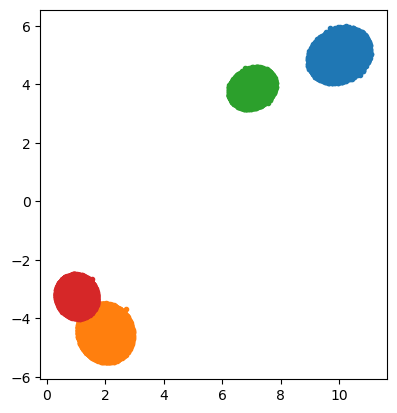

In [23]:
plotutil.plotImagesData(iws.backProject(nsie) + iws.backProject(complexDegen))
plt.gca().set_aspect("equal")

In [24]:
bp1, bp2 = iws.backProject(complexDegen)
src1New = images.createSourceFromImagesData(bp1)
src2New = images.createSourceFromImagesData(bp2)

In [25]:
lensInfoComplexDegen = plotutil.LensInfo(complexDegen, size=80*ANGLE_ARCSEC, numxy=1023, zd=zd, zs=zs1, cosmology=cosm)

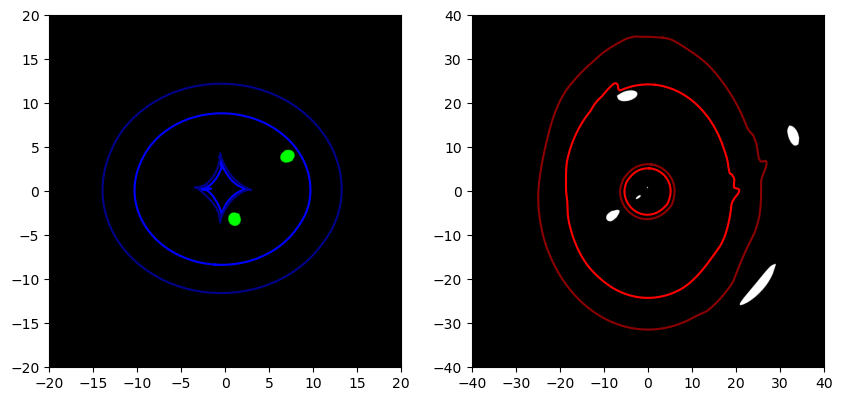

In [26]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plotutil.plotImagePlane(lensInfoComplexDegen, sources=[
    { "shape": src1New, "z": zs1 },
    { "shape": src2New, "z": zs2 }
], critColor = [ 'red', 'darkred'], caustColor = [ 'blue', 'darkblue'], plotCriticalLines=False, plotImages=False)
plt.gca().set_xlim([-20,20])
plt.gca().set_ylim([-20,20]);
plt.subplot(1,2,2)
plotutil.plotImagePlane(lensInfoComplexDegen, sources=[
    { "shape": src1New, "z": zs1 },
    { "shape": src2New, "z": zs2 }
], critColor = [ 'red', 'darkred'], caustColor = [ 'blue', 'darkblue'], plotCaustics=False, plotSources=False)


In [27]:
lensInfoComplexDegen2 = plotutil.LensInfo(complexDegen, size=120*ANGLE_ARCSEC, numxy=1023, zd=zd, zs=zs1, cosmology=cosm)

(<grale.plotutil.LensInfo at 0x7f2291248290>, None, None)

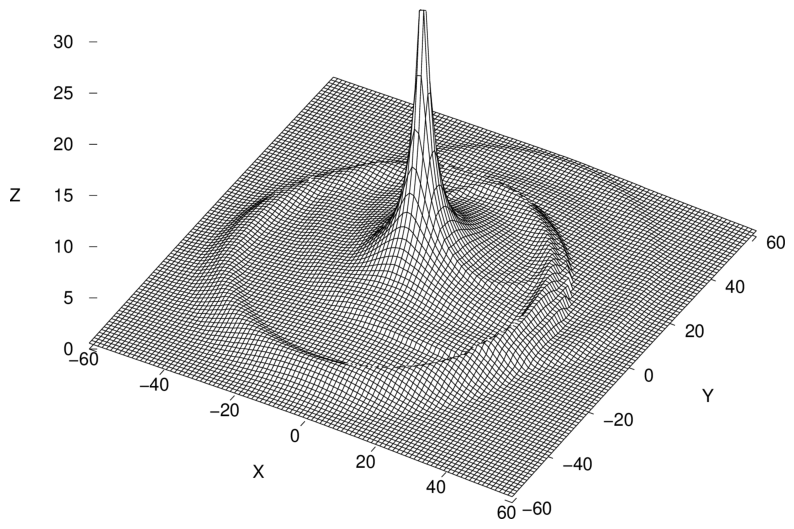

In [28]:
plt.figure(figsize=(10, 10))
plotutil.plotDensityGnuplot(lensInfoComplexDegen2, numX=100, numY=100, color=False, rotationX=45, rotationZ=30)

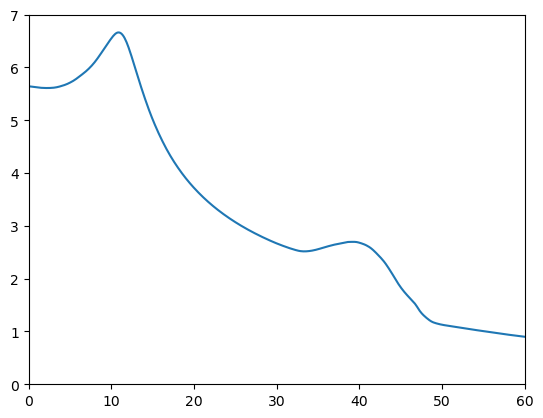

In [29]:
plotutil.plotAverageDensityProfile(complexDegen, 60*ANGLE_ARCSEC, V(-8,-8)*ANGLE_ARCSEC)
plt.gca().set_xlim([0,60])
plt.gca().set_ylim([0,7]);